# Getting taxonomy from NCBI with `R` & `rentrez`

Recently, I happened to work with Blast a lot. At some point we wanted to get some high-level taxonomy for our dataset. I've never done this, but I know the NCBI provides a query interface called Entrez, which can be accessed from command-line tools as well as from several programming languages. In `R`, you can query the Entrez system with the [`rentrez`](https://cran.r-project.org/package=rentrez) package. Here I describe the basics of getting taxonomy information with this package.

Let's load our packages - `rentrez` and also `magrittr` (to get pipes for easier coding):

In [1]:
options(repr.plot.width=7, repr.plot.height=7, jupyter.plot_scale = 1)

library(magrittr)
library(rentrez)

Here is the list of available databases:

In [2]:
entrez_dbs()

[1] "pubmed"          "protein"         "nuccore"         "ipg"            
 [5] "nucleotide"      "structure"       "genome"          "annotinfo"      
 [9] "assembly"        "bioproject"      "biosample"       "blastdbinfo"    
[13] "books"           "cdd"             "clinvar"         "gap"            
[17] "gapplus"         "grasp"           "dbvar"           "gene"           
[21] "gds"             "geoprofiles"     "homologene"      "medgen"         
[25] "mesh"            "ncbisearch"      "nlmcatalog"      "omim"           
[29] "orgtrack"        "pmc"             "popset"          "proteinclusters"
[33] "pcassay"         "protfam"         "biosystems"      "pccompound"     
[37] "pcsubstance"     "seqannot"        "snp"             "sra"            
[41] "taxonomy"        "biocollections"  "gtr"

The basic command to get taxonomy for an ID:

In [3]:
taxo <- entrez_summary(db="taxonomy", id="1219383")
str(taxo)

List of 13
 $ uid             : chr "1219383"
 $ status          : chr "active"
 $ rank            : chr "species"
 $ division        : chr "g-proteobacteria"
 $ scientificname  : chr "Acinetobacter boissieri"
 $ commonname      : chr ""
 $ taxid           : int 1219383
 $ akataxid        : chr ""
 $ genus           : chr "Acinetobacter"
 $ species         : chr "boissieri"
 $ subsp           : chr ""
 $ modificationdate: chr "2015/07/31 00:00"
 $ genbankdivision : chr "Bacteria"
 - attr(*, "class")= chr [1:2] "esummary" "list"


You can extract just the part you want with `$`:

In [4]:
entrez_summary(db="taxonomy", id="1219383")$division

[1] "g-proteobacteria"

## Search & links

But suppose for a moment that we do not have the `staxids` - can we still get this information with e.g. accession number (`saccver` or similar)?

Of course we can!

Let's say we want to search the taxonomy for accession number `WP_092748568.1`. We start by searching the **protein database**, where the accession number comes from:

In [5]:
entrez_search(db="protein", term="WP_092748568.1")

Entrez search result with 1 hits (object contains 1 IDs and no web_history object)
 Search term (as translated):   

We see there is 1 hit, but it doesn't show any information about it - yet. You could save the result of the query into an object and expect it with `str()` - or we can use `magrittr` pipe directly on the query:

In [6]:
entrez_search(db="protein", term="WP_092748568.1") %>% str

List of 5
 $ ids             : chr "1224730548"
 $ count           : int 1
 $ retmax          : int 1
 $ QueryTranslation: chr ""
 $ file            :Classes 'XMLInternalDocument', 'XMLAbstractDocument' <externalptr> 
 - attr(*, "class")= chr [1:2] "esearch" "list"


Now we can see the **internal NCBI ID** of this item, under the `$ids` slot. We can now look up what other information is *linked* to this ID:

In [7]:
ncbi_id <- entrez_search(db="protein", term="WP_092748568.1")$ids

entrez_link(dbfrom="protein", id=ncbi_id, db="all") %>% str

List of 2
 $ links:List of 16
  ..$ protein_cdd                    : chr [1:16] "415644" "399551" "395146" "236886" ...
  ..$ protein_cdd_concise_2          : chr "163712"
  ..$ protein_cdd_specific_2         : chr "163712"
  ..$ protein_cdd_summary_nonpublic  : chr [1:13] "395146" "223824" "215328" "215003" ...
  ..$ protein_cdd_superfamily_2      : chr "415644"
  ..$ protein_nuccore                : chr "1224732327"
  ..$ protein_protein_cdart_summary  : chr "1224730548"
  ..$ protein_sparcle                : chr "10169238"
  ..$ protein_taxonomy               : chr "1219383"
  ..$ protein_bioproject             : chr "224116"
  ..$ protein_cdd_summary            : chr [1:16] "415644" "399551" "395146" "236886" ...
  ..$ protein_nuccore_wp             : chr "1224732327"
  ..$ protein_protein_cdart          : chr "1224730548"
  ..$ protein_protein_cdart_summary_2: chr "1224730548"
  ..$ protein_protfam                : chr [1:7] "326225" "315947" "246230" "246128" ...
  ..$ protein_ta

As we can see, there is a link to the **taxonomy database**, showing us an id "1219382". Now we can reuse this ID in our query:

In [8]:
our_id <- entrez_link(dbfrom="protein", id=ncbi_id, db="all")$links$protein_taxonomy

entrez_summary(db="taxonomy", id=our_id) %>% str

List of 13
 $ uid             : chr "1219383"
 $ status          : chr "active"
 $ rank            : chr "species"
 $ division        : chr "g-proteobacteria"
 $ scientificname  : chr "Acinetobacter boissieri"
 $ commonname      : chr ""
 $ taxid           : int 1219383
 $ akataxid        : chr ""
 $ genus           : chr "Acinetobacter"
 $ species         : chr "boissieri"
 $ subsp           : chr ""
 $ modificationdate: chr "2015/07/31 00:00"
 $ genbankdivision : chr "Bacteria"
 - attr(*, "class")= chr [1:2] "esummary" "list"


Cool. Now we can get taxonomic information for one sample. But what if we have 5 - or 5000?

Yes we can! In particular, we can supply most of the functions we used with a *vector of IDs* instead of just one ID. But let's get some data first.

## Real data - Blast output

I started with a `blastp` output in tabular format with few extra columns - in particular the accession number and Tax ID, so you need at least this: `-outfmt '7 saccver staxids'` to get taxonomy IDs for your blast hits (note that `saccver` is part of standard blast output, which can be specified with the `std` format keyword).

> **Note:** You can also ask blast to provide e.g. scientific names, however so many of them were missing in my queries that I just gave up on using that.

Since `staxids` can include multiple IDs separated by `;`, I had to process the data slightly with `awk` before they were ready:

```bash
# take columns 2 (saccver) and 13 (staxids) from blast output table (skipping header)
awk -F"\t" '!/#/ {print $2, $13}' blastp_outfmt7_std_staxids.tsv > blastp_saccver_staxids.txt

# expand items with multiple staxids row-wise by replacing ";" with "newline+saccver+space"
awk '{gsub(/;/, "\n"$1" ", $2); print $0}' blastp_saccver_staxids.txt > blastp_saccver_staxids_expanded.txt
```

Now we are ready to load the data into `R`:

In [9]:
taxa <- read.table("blastp_saccver_staxids_expanded.txt", h=F, sep=" ") #, stringsAsFactors = T)
colnames(taxa) <- c("acc", "id")
str(taxa)

'data.frame':	13842 obs. of  2 variables:
 $ acc: chr  "WP_092748568.1" "WP_023273437.1" "WP_023273437.1" "WP_088823490.1" ...
 $ id : int  1219383 1219382 1392540 1229165 29545 2691581 1907941 86304 203122 2675457 ...


### Test data (10 ids)
So far we used the function `str()` to see results of our queries and to figure out which data to extract with `$`. Of course this is not practical for bulk queries with multiple IDs. For this reason there is a helper function - `extract_from_esummary()`. It accepts a list of results from your query and a name of the field you want to extract. We can pipe into it as usual:

In [10]:
entrez_summary(db="taxonomy", id=taxa$id[1:10]) %>% extract_from_esummary("division")

1219383            1219382            1392540            1229165 
"g-proteobacteria" "g-proteobacteria" "g-proteobacteria" "g-proteobacteria" 
             29545            2691581            1907941              86304 
"b-proteobacteria" "b-proteobacteria" "g-proteobacteria" "g-proteobacteria" 
            203122            2675457 
"g-proteobacteria" "b-proteobacteria"

### Full data (~90k ids)

The basic command to extract taxonomy through Entrez looks like this:

```R
entrez_summary(db="taxonomy", id=taxa$id) %>% extract_from_esummary("division")
```

I cannot actually ask Entrez to give me all data at once - they limit queries to certain (unknown) size. After a bit of experimenting, I found I can get **400 items at a time**. So in reality, we need to divide the data into chunks and loop over the chunks to get the full dataset.

> **Note:** the `rentrez` [tutorial](https://cran.r-project.org/web/packages/rentrez/vignettes/rentrez_tutorial.html) says I should use **web history** feature for large queries, however **this option has the same limit** on items as getting them directly. So I skipped web history and just got the stuff I needed directly. `¯\_(ツ)_/¯`

In [11]:
nrow(taxa)
(nrow(taxa)/400) %>% round

[1] 13842

[1] 35

[Divide data into chunks](https://stackoverflow.com/a/3321659) of 400 IDs and store them in a list:

In [12]:
id_list <- (seq_along(taxa$id)/400) %>% ceiling %>% split(taxa$id,.)

Use `lapply` to loop over the list using our extraction command:

In [13]:
all_division <- lapply(id_list, function(x) {entrez_summary(db="taxonomy", id=x) %>%
                             extract_from_esummary(., "division")})

Warning message:
“ID 332056 produced error 'cannot get document summary'”
Warning message:
“ID 2044510 produced error 'cannot get document summary'”
Warning message:
“ID 2694937 produced error 'cannot get document summary'”
Warning message:
“ID 2024862 produced error 'cannot get document summary'”
Warning message:
“ID 2660640 produced error 'cannot get document summary'”
Warning message:
“ID 2660639 produced error 'cannot get document summary'”
Warning message:
“ID 2731243 produced error 'cannot get document summary'”
Warning message:
“ID 1330039 produced error 'cannot get document summary'”
Warning message:
“ID 262776 produced error 'cannot get document summary'”
Warning message:
“ID 2529841 produced error 'cannot get document summary'”
Warning message:
“ID 2731248 produced error 'cannot get document summary'”
Warning message:
“ID 2731248 produced error 'cannot get document summary'”
Warning message:
“ID 2529844 produced error 'cannot get document summary'”
Warning message:
“ID 332056

Now we can see the taxonomic representation in our dataset.

> Note the `magrittr` "T-pipe" `%T>%` in the following command - it alows side-piping data into a plot, but also reusing it (here for printing the output of `table`). The extra pipes are the main reason I use the original `magrittr` package instead of e.g. `dplyr`.

.
     g-proteobacteria      e-proteobacteria      b-proteobacteria 
                 4419                  2066                  1749 
           firmicutes      a-proteobacteria    CFB group bacteria 
                 1671                  1418                   867 
             bacteria         high GC Gram+        enterobacteria 
                  483                   302                   193 
     d-proteobacteria         cyanobacteria                       
                  176                   140                    65 
       proteobacteria          GNS bacteria        euryarchaeotes 
                   52                    51                    44 
      verrucomicrobia               archaea        planctomycetes 
                   43                    20                    18 
          spirochetes        actinobacteria        kinetoplastids 
                   18                     7                     6 
green sulfur bacteria        crenarchaeotes         thermoto

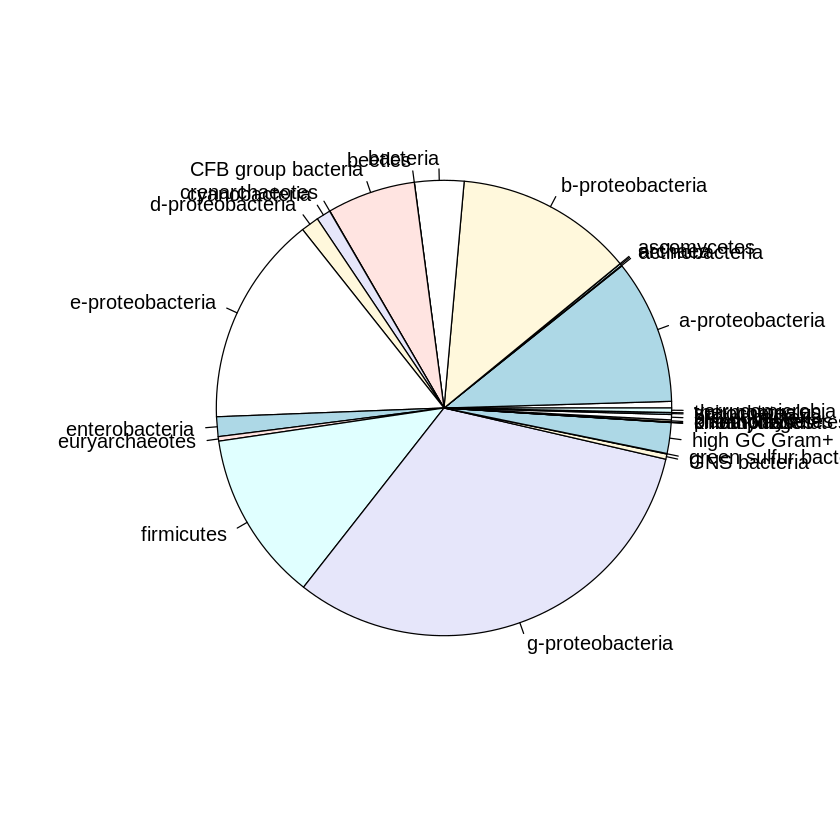

In [14]:
all_division %>% unlist %>% table %T>% pie %>% sort(decreasing=T)

Wow, pretty... ugly. Let's see what `ggplot2` can do..

## ggplot, just for fun

In [15]:
library(ggplot2)

In [16]:
df <- all_division %>% unlist %>% table %>% as.data.frame

colnames(df) <- c("Taxon", "Freq")
head(df)

,Taxon,Freq
,<fct>,<int>
1,,65
2,a-proteobacteria,1418
3,actinobacteria,7
4,archaea,20
5,ascomycetes,1
6,b-proteobacteria,1749


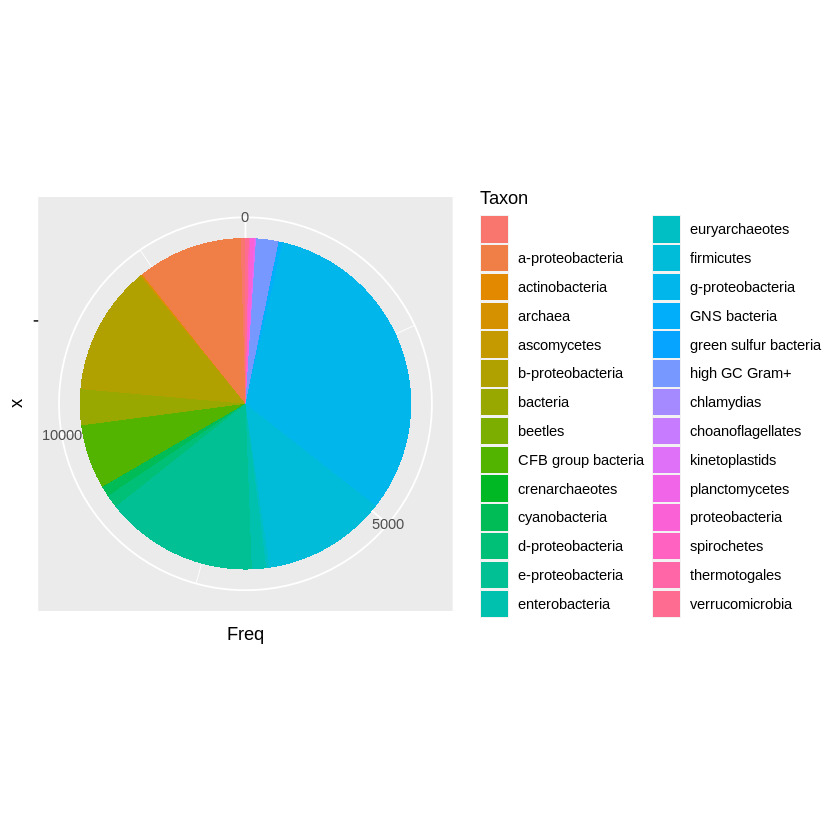

In [17]:
ggplot(df, aes(x = "", y = Freq, fill = Taxon)) +
  geom_col() +
  coord_polar(theta = "y")

It is much nicer looking, but I actually have a problem distinguishing the different colours in the plot. I *am* colourblind, sure, but I think there is just too many colours for anyone to handle.

In [18]:
df$Taxon %>% unique %>% length

[1] 28

**28 categories** - that's a lot! Well I think for this amount of data the base R is better - by default. There might be a way to improve both plots, but this is not the time nor place. See you next time 😉️